# PD Model - Feature selection and engineering

## Imports / load of preporcessed data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
loan_data = pd.read_csv('loan_data_2007_2014_processed.csv', index_col="Unnamed: 0")

/Users/graystone/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (20,48) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
loan_data.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,addr_state TX,addr_state UT,addr_state VA,addr_state VT,addr_state WA,addr_state WI,addr_state WV,addr_state WY,initial_list_status f,initial_list_status w
0,1077501,1296599,5000,5000,4975.0,36 months,10.65,162.87,B,B2,...,0,0,0,0,0,0,0,0,1,0
1,1077430,1314167,2500,2500,2500.0,60 months,15.27,59.83,C,C4,...,0,0,0,0,0,0,0,0,1,0
2,1077175,1313524,2400,2400,2400.0,36 months,15.96,84.33,C,C5,...,0,0,0,0,0,0,0,0,1,0
3,1076863,1277178,10000,10000,10000.0,36 months,13.49,339.31,C,C1,...,0,0,0,0,0,0,0,0,1,0
4,1075358,1311748,3000,3000,3000.0,60 months,12.69,67.79,B,B5,...,0,0,0,0,0,0,0,0,1,0


## More data preparation for PD model

### Dependent Variable. Set the Default definition

In [4]:
loan_data['loan_status'].unique()

array(['Fully Paid', 'Charged Off', 'Current', 'Default',
       'Late (31-120 days)', 'In Grace Period', 'Late (16-30 days)',
       'Does not meet the credit policy. Status:Fully Paid',
       'Does not meet the credit policy. Status:Charged Off'],
      dtype=object)

In [5]:
loan_data['loan_status'].value_counts() / loan_data['loan_status'].count()

Current                                                0.480878
Fully Paid                                             0.396193
Charged Off                                            0.091092
Late (31-120 days)                                     0.014798
In Grace Period                                        0.006747
Does not meet the credit policy. Status:Fully Paid     0.004263
Late (16-30 days)                                      0.002612
Default                                                0.001784
Does not meet the credit policy. Status:Charged Off    0.001632
Name: loan_status, dtype: float64

This shows that Charged off accounts are 9% of the total population

Let us define our Default. The following statuses fall under the Default definition (hence receive an indicator of '0', while the rest will receive indicator or '1')

In [6]:
loan_data['good_bad'] = np.where(loan_data['loan_status'].isin(['Charged Off',
                                                                'Default',
                                                                'Does not meet the credit policy. Status:Charged Off',
                                                               'Late (31-120 days)']), 0, 1)

In [7]:
loan_data['good_bad'].value_counts() / loan_data['good_bad'].count()

1    0.890693
0    0.109307
Name: good_bad, dtype: float64

Above summary shows that 89% of the loans are in non-default status while 10.9% is in Default based on our definition of Default

### Weight of Evidence and Information Value

Weight of evidence (WOE) and Information value (IV) are simple, yet powerful techniques to perform variable transformation and selection. These concepts have huge connection with the logistic regression modeling technique. It is widely used in credit scoring to measure the separation of good vs bad loans.

The formula to calculate WOE and IV is provided below.

![alt text](pics/WoE.png "Weight of Evidence")

![alt text](pics/IV.png "Information Value")

![alt text](pics/Iv_simple.png "Information Value Simple")

IV can be used to select variables used in a model See a general rule of thumb selection model below

![alt text](pics/power.png "Predictive Power")

#### Ultimately the IV is a pre-selection process of Variables. If some this helps select Variables quickly and reduce model runtime by dropping useless or non-predictive Variables

#### Descrete Variables

In [8]:
def IV_calculation_multi(dataset, columns, target):
    
    for idx in columns:
        temp = pd.crosstab(dataset[idx], dataset[target])
        temp.rename(columns ={0:'Bad', 1:'Good'}, errors ='raise', inplace=True)
        temp['Portion Good(1)'] = (temp['Good'] / temp['Good'].sum())
        temp['Portion Bad(0)'] = (temp['Bad'] / temp['Bad'].sum())
        try: temp['WoE'] = np.log((temp['Portion Good(1)'] / temp['Portion Bad(0)']))
        except: 0
        try: temp['Good-Bad'] = temp['Portion Good(1)'] - temp['Portion Bad(0)']
        except: 0
        try: temp['IV'] = temp['WoE'] * temp['Good-Bad']
        except: 0   
        print("The Information Value of {} is {}" .format(idx,temp['IV'].sum()))

In [69]:
def IV_calculation_single(dataset, column, target, sort=True):
    temp = pd.crosstab(dataset[column], dataset[target])
    temp.rename(columns ={0:'Bad', 1:'Good'}, errors ='raise', inplace=True)
    temp['Portion Good(1)'] = (temp['Good'] / temp['Good'].sum())
    temp['Portion Bad(0)'] = (temp['Bad'] / temp['Bad'].sum())
    try: temp['WoE'] = np.log((temp['Portion Good(1)'] / temp['Portion Bad(0)']))
    except: 0
    try: temp['Good-Bad'] = temp['Portion Good(1)'] - temp['Portion Bad(0)']
    except: 0
    try: temp['IV'] = temp['WoE'] * temp['Good-Bad']
    except: 0
    temp['IV'] = temp['IV'].sum()
    if sort is True:
        temp.sort_values(by=['WoE'], ascending=True, inplace=True)
    else: pass
    
    return temp    

In [100]:
def plot_by_woe(df_WoE, rotation_of_x_axis_labels = 0):
    x = np.array(df_WoE.index.values).astype(str)
    y = df_WoE['WoE']
    plt.figure(figsize = (18, 6))
    plt.plot(x, y, marker = 'o', linestyle = '--', color = 'k')
    plt.xlabel(df_WoE.index.name)
    plt.ylabel('Weight of Evidence')
    plt.title(str('Weight of Evidence by ' + df_WoE.index.name))
    plt.xticks(rotation = rotation_of_x_axis_labels)

Let's apply the IV formulas to some selected features:

In [70]:
columns=['grade', 'home_ownership', 'addr_state', 'verification_status', 'purpose', 'initial_list_status']
IV_calculation_multi(loan_data,columns, 'good_bad')

The Information Value of grade is 0.29078213954085946
The Information Value of home_ownership is inf
The Information Value of addr_state is inf
The Information Value of verification_status is 0.02083140423458036
The Information Value of purpose is 0.03698019471958764
The Information Value of initial_list_status is 0.024801321308399786


For continuous variables we need to preprocess the data first! Also, "sort" argument set to True for decrete, beneficial to set to False for continous

good_bad,Bad,Good,Portion Good(1),Portion Bad(0),WoE,Good-Bad,IV
grade,,,,,,,
G,924,2398,0.005774,0.018129,-1.144166,-0.012355,0.290782
F,3192,10037,0.024167,0.062628,-0.952214,-0.038460,0.290782
E,6964,28793,0.069328,0.136635,-0.678466,-0.067307,0.290782
D,11848,65040,0.156603,0.232460,-0.395001,-0.075856,0.290782
C,14384,110909,0.267047,0.282216,-0.055251,-0.015170,0.290782
B,10759,126170,0.303792,0.211093,0.364043,0.092699,0.290782
A,2897,71970,0.173289,0.056840,1.114730,0.116450,0.290782


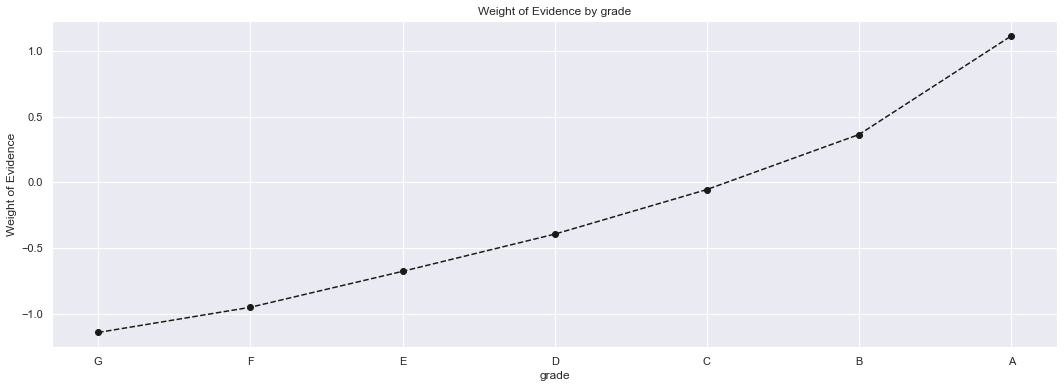

In [101]:
grade = IV_calculation_single(loan_data,'grade', 'good_bad')
plot_by_woe(grade)
grade

good_bad,Bad,Good,Portion Good(1),Portion Bad(0),WoE,Good-Bad,IV
home_ownership,,,,,,,
OTHER,38,144,0.000347,0.000746,-0.765617,-0.000399,inf
NONE,8,42,0.000101,0.000157,-0.439616,-0.000056,inf
RENT,23767,164706,0.396579,0.466312,-0.161980,-0.069733,inf
OWN,4515,37189,0.089544,0.088585,0.010764,0.000959,inf
MORTGAGE,22640,213235,0.513427,0.444200,0.144832,0.069227,inf
ANY,0,1,0.000002,0.000000,inf,0.000002,inf


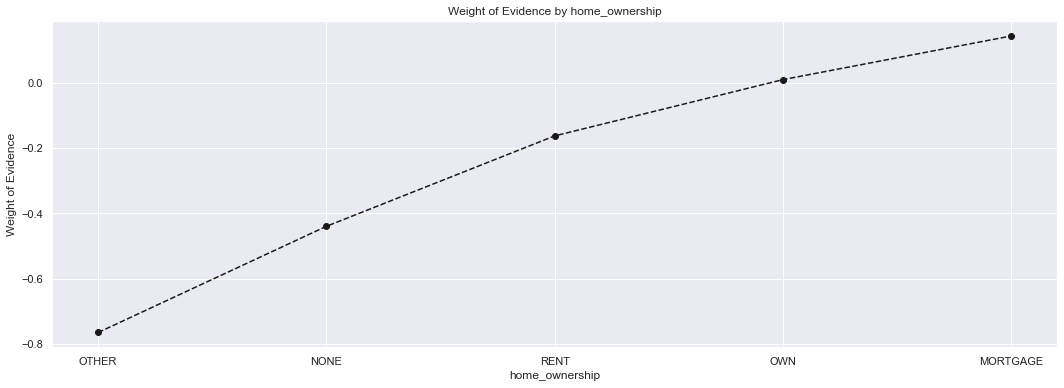

In [73]:
home_ownership = IV_calculation_single(loan_data,'home_ownership', 'good_bad')
plot_by_woe(home_ownership)
home_ownership

In [54]:
loan_data['home_ownership RENT_OTHER_NONE_ANY'] = sum([loan_data['home_ownership RENT'], loan_data['home_ownership OTHER'],loan_data['home_ownership NONE'], loan_data['home_ownership ANY']])

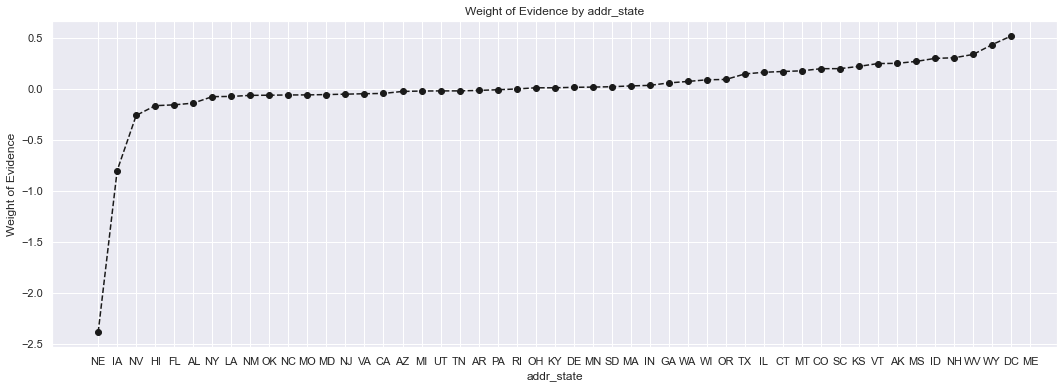

In [48]:
addr_state = IV_calculation_single(loan_data,'addr_state', 'good_bad')
plot_by_woe(addr_state)

In [57]:
if ['addr_state ND'] in loan_data.columns.values:
    pass
else:
    loan_data['addr_state ND'] = 0 

In [59]:
loan_data['addr_state ND_NE_IA_NV_FL_HI_AL'] = sum([loan_data['addr_state ND'], loan_data['addr_state NE'],
                                                         loan_data['addr_state IA'], loan_data['addr_state NV'],
                                                         loan_data['addr_state FL'], loan_data['addr_state HI'],
                                                         loan_data['addr_state AL']])

loan_data['addr_state NM_VA'] = sum([loan_data['addr_state NM'], loan_data['addr_state VA']])

loan_data['addr_state OK_TN_MO_LA_MD_NC'] = sum([loan_data['addr_state OK'], loan_data['addr_state TN'],
                                              loan_data['addr_state MO'], loan_data['addr_state LA'],
                                              loan_data['addr_state MD'], loan_data['addr_state NC']])

loan_data['addr_state UT_KY_AZ_NJ'] = sum([loan_data['addr_state UT'], loan_data['addr_state KY'],
                                              loan_data['addr_state AZ'], loan_data['addr_state NJ']])

loan_data['addr_state AR_MI_PA_OH_MN'] = sum([loan_data['addr_state AR'], loan_data['addr_state MI'],
                                              loan_data['addr_state PA'], loan_data['addr_state OH'],
                                              loan_data['addr_state MN']])

loan_data['addr_state RI_MA_DE_SD_IN'] = sum([loan_data['addr_state RI'], loan_data['addr_state MA'],
                                              loan_data['addr_state DE'], loan_data['addr_state SD'],
                                              loan_data['addr_state IN']])

loan_data['addr_state GA_WA_OR'] = sum([loan_data['addr_state GA'], loan_data['addr_state WA'],
                                              loan_data['addr_state OR']])

loan_data['addr_state WI_MT'] = sum([loan_data['addr_state WI'], loan_data['addr_state MT']])

loan_data['addr_state IL_CT'] = sum([loan_data['addr_state IL'], loan_data['addr_state CT']])

loan_data['addr_state KS_SC_CO_VT_AK_MS'] = sum([loan_data['addr_state KS'], loan_data['addr_state SC'],
                                              loan_data['addr_state CO'], loan_data['addr_state VT'],
                                              loan_data['addr_state AK'], loan_data['addr_state MS']])

loan_data['addr_state WV_NH_WY_DC_ME_ID'] = sum([loan_data['addr_state WV'], loan_data['addr_state NH'],
                                              loan_data['addr_state WY'], loan_data['addr_state DC'],
                                              loan_data['addr_state ME'], loan_data['addr_state ID']])

good_bad,Bad,Good,Portion Good(1),Portion Bad(0),WoE,Good-Bad,IV
verification_status,,,,,,,
Verified,21405,146650,0.353104,0.419969,-0.173420,-0.066866,0.020831
Source Verified,15617,134376,0.323550,0.306408,0.054438,0.017143,0.020831
Not Verified,13946,134291,0.323346,0.273623,0.166972,0.049723,0.020831


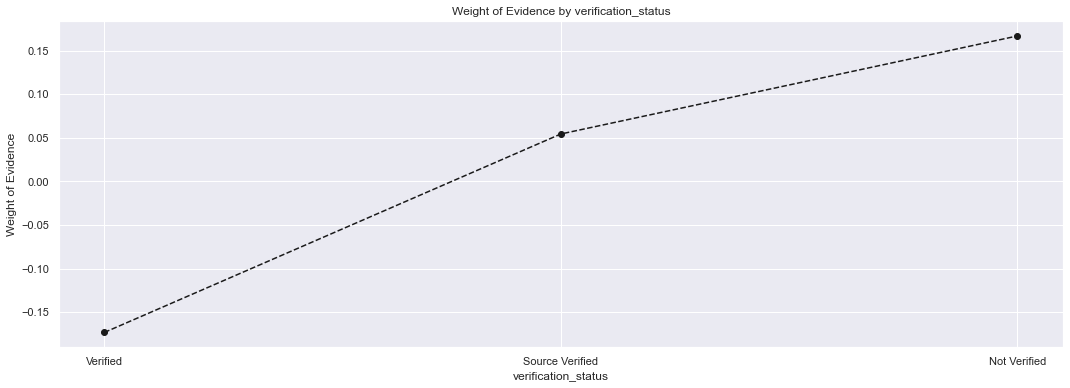

In [61]:
verification_status = IV_calculation_single(loan_data,'verification_status', 'good_bad')
plot_by_woe(verification_status)
verification_status

good_bad,Bad,Good,Portion Good(1),Portion Bad(0),WoE,Good-Bad,IV
purpose,,,,,,,
small_business,1513,5500,0.013243,0.029685,-0.807190,-0.016442,0.03698
educational,88,334,0.000804,0.001727,-0.764040,-0.000922,0.03698
renewable_energy,54,297,0.000715,0.001059,-0.393096,-0.000344,0.03698
moving,457,2537,0.006109,0.008966,-0.383790,-0.002858,0.03698
house,318,1951,0.004698,0.006239,-0.283798,-0.001542,0.03698
other,3269,20421,0.049170,0.064138,-0.265764,-0.014969,0.03698
medical,616,3986,0.009597,0.012086,-0.230548,-0.002489,0.03698
wedding,285,2058,0.004955,0.005592,-0.120843,-0.000636,0.03698
vacation,293,2194,0.005283,0.005749,-0.084535,-0.000466,0.03698


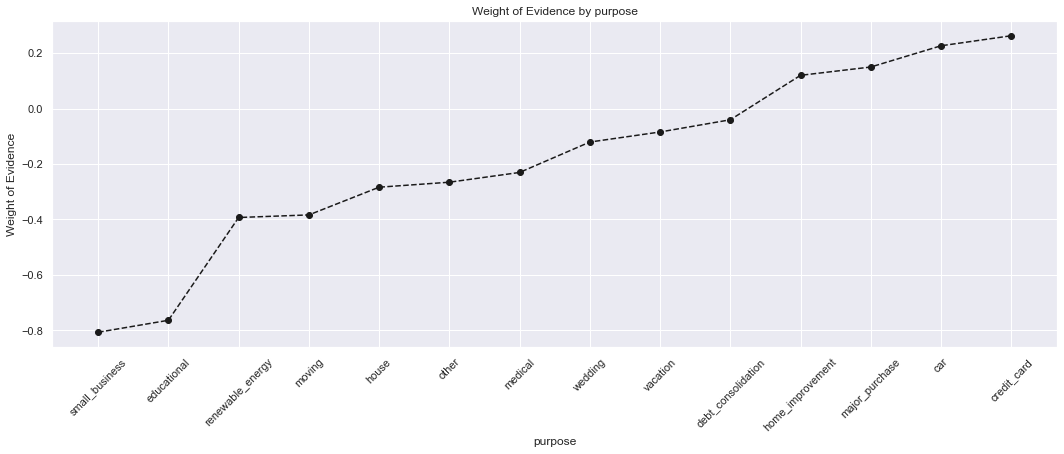

In [64]:
purpose = IV_calculation_single(loan_data,'purpose', 'good_bad')
plot_by_woe(purpose,45)
purpose

In [67]:
loan_data['purpose educ__sm_b__wedd__ren_en__mov__house'] = sum([loan_data['purpose educational'], loan_data['purpose small_business'],
                                                                 loan_data['purpose wedding'], loan_data['purpose renewable_energy'],
                                                                 loan_data['purpose moving'], loan_data['purpose house']])
loan_data['purpose oth__med__vacation'] = sum([loan_data['purpose other'], loan_data['purpose medical'],
                                             loan_data['purpose vacation']])
loan_data['purpose major_purch__car__home_impr'] = sum([loan_data['purpose major_purchase'], loan_data['purpose car'],
                                                        loan_data['purpose home_improvement']])

#### Continous Variables

In [74]:
loan_data['term_int'].unique()

array([36, 60])

good_bad,Bad,Good,Portion Good(1),Portion Bad(0),WoE,Good-Bad,IV
term_int,,,,,,,
36,32810,305143,0.734723,0.643737,0.132203,0.090986,0.03886
60,18158,110174,0.265277,0.356263,-0.294894,-0.090986,0.03886


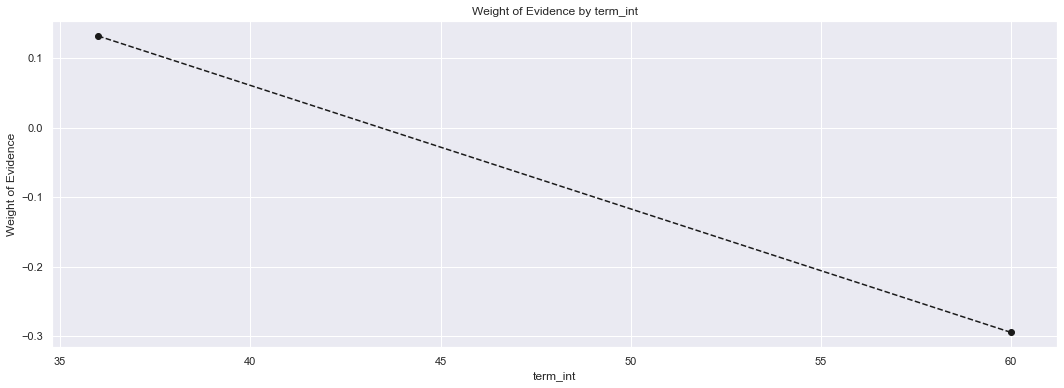

In [75]:
term = IV_calculation_single(loan_data,'term_int', 'good_bad', sort=False)
plot_by_woe(term)
term

In [76]:
loan_data['term 36'] = np.where((loan_data['term_int'] == 36), 1, 0)
loan_data['term 60'] = np.where((loan_data['term_int'] == 60), 1, 0)

In [79]:
loan_data['emp_length_int'].unique()

array([10.,  0.,  1.,  3.,  8.,  9.,  4.,  5.,  6.,  2.,  7.])

good_bad,Bad,Good,Portion Good(1),Portion Bad(0),WoE,Good-Bad,IV
emp_length_int,,,,,,,
0.0,7101,50172,0.120804,0.139323,-0.142623,-0.018519,0.006611
1.0,3314,26308,0.063344,0.065021,-0.026127,-0.001677,0.006611
2.0,4541,36832,0.088684,0.089095,-0.004624,-0.000411,0.006611
3.0,4008,32588,0.078465,0.078638,-0.002192,-0.000172,0.006611
4.0,3071,24952,0.060079,0.060253,-0.002893,-0.000174,0.006611
5.0,3538,27236,0.065579,0.069416,-0.056866,-0.003837,0.006611
6.0,3058,23054,0.055509,0.059998,-0.077766,-0.004489,0.006611
7.0,2915,23265,0.056017,0.057193,-0.020764,-0.001175,0.006611
8.0,2465,19930,0.047987,0.048364,-0.007810,-0.000376,0.006611


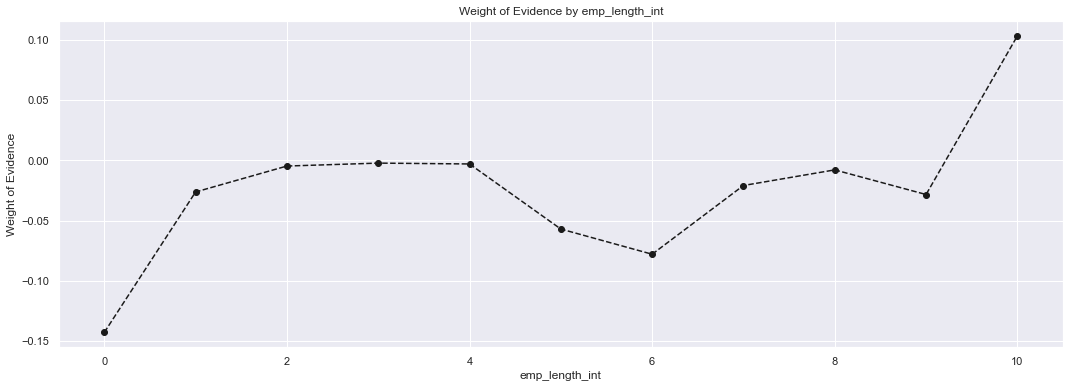

In [80]:
emp = IV_calculation_single(loan_data,'emp_length_int', 'good_bad', sort=False)
plot_by_woe(emp)
emp

In [81]:
loan_data['emp_length 0'] = np.where(loan_data['emp_length_int'].isin([0]), 1, 0)
loan_data['emp_length 1'] = np.where(loan_data['emp_length_int'].isin([1]), 1, 0)
loan_data['emp_length 2-4'] = np.where(loan_data['emp_length_int'].isin(range(2, 5)), 1, 0)
loan_data['emp_length 5-6'] = np.where(loan_data['emp_length_int'].isin(range(5, 7)), 1, 0)
loan_data['emp_length 7-9'] = np.where(loan_data['emp_length_int'].isin(range(7, 10)), 1, 0)
loan_data['emp_length 10'] = np.where(loan_data['emp_length_int'].isin([10]), 1, 0)

In [82]:
loan_data.columns.values

array(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade',
       'emp_title', 'emp_length', 'home_ownership', 'annual_inc',
       'verification_status', 'issue_d', 'loan_status', 'pymnt_plan',
       'url', 'desc', 'purpose', 'title', 'zip_code', 'addr_state', 'dti',
       'delinq_2yrs', 'earliest_cr_line', 'inq_last_6mths',
       'mths_since_last_delinq', 'mths_since_last_record', 'open_acc',
       'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt',
       'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d',
       'last_credit_pull_d', 'collections_12_mths_ex_med',
       'mths_since_last_major_derog', 'policy_code', 'application_type',
       'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal',
       'to

In [83]:
loan_data['months_issue_d'].unique()

array([ 72.,  73.,  74.,  75.,  76.,  77.,  78.,  79.,  80.,  81.,  82.,
        83.,  84.,  85.,  86.,  87.,  88.,  89.,  90.,  91.,  92.,  93.,
        94.,  95.,  96.,  97.,  98.,  99., 100., 101., 102., 103., 104.,
       105., 106., 107., 108., 109., 110., 111., 112., 113., 114., 115.,
       116., 117., 118., 119., 120., 121., 122., 123., 124., 125., 126.,
        48.,  49.,  50.,  51.,  52.,  53.,  54.,  55.,  56.,  57.,  58.,
        59.,  60.,  61.,  62.,  63.,  64.,  65.,  66.,  67.,  68.,  69.,
        70.,  71.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,
        45.,  46.,  47.])

Fine classing and Coarse classing are required here. 

Fine Classing:

In [84]:
loan_data['months_issue_d_factor'] = pd.cut(loan_data['months_issue_d'], 50)
loan_data['months_issue_d_factor']

0         (70.2, 72.0]
1         (70.2, 72.0]
2         (70.2, 72.0]
3         (70.2, 72.0]
4         (70.2, 72.0]
              ...     
466280    (46.8, 48.6]
466281    (46.8, 48.6]
466282    (46.8, 48.6]
466283    (46.8, 48.6]
466284    (46.8, 48.6]
Name: months_issue_d_factor, Length: 466285, dtype: category
Categories (50, interval[float64]): [(35.91, 37.8] < (37.8, 39.6] < (39.6, 41.4] < (41.4, 43.2] ... (118.8, 120.6] < (120.6, 122.4] < (122.4, 124.2] < (124.2, 126.0]]

In [86]:
loan_data.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,purpose major_purch__car__home_impr,term 36,term 60,emp_length 0,emp_length 1,emp_length 2-4,emp_length 5-6,emp_length 7-9,emp_length 10,months_issue_d_factor
0,1077501,1296599,5000,5000,4975.0,36 months,10.65,162.87,B,B2,...,0,1,0,0,0,0,0,0,1,"(70.2, 72.0]"
1,1077430,1314167,2500,2500,2500.0,60 months,15.27,59.83,C,C4,...,1,0,1,1,0,0,0,0,0,"(70.2, 72.0]"
2,1077175,1313524,2400,2400,2400.0,36 months,15.96,84.33,C,C5,...,0,1,0,0,0,0,0,0,1,"(70.2, 72.0]"
3,1076863,1277178,10000,10000,10000.0,36 months,13.49,339.31,C,C1,...,0,1,0,0,0,0,0,0,1,"(70.2, 72.0]"
4,1075358,1311748,3000,3000,3000.0,60 months,12.69,67.79,B,B5,...,0,0,1,0,1,0,0,0,0,"(70.2, 72.0]"


good_bad,Bad,Good,Portion Good(1),Portion Bad(0),WoE,Good-Bad,IV
months_issue_d_factor,,,,,,,
"(35.91, 37.8]",2017,33344,0.080286,0.039574,0.707422,0.040712,0.114799
"(37.8, 39.6]",3516,45872,0.110451,0.068984,0.470687,0.041466,0.114799
"(39.6, 41.4]",3955,44165,0.106340,0.077598,0.315108,0.028743,0.114799
"(41.4, 43.2]",3312,32966,0.079376,0.064982,0.200080,0.014394,0.114799
"(43.2, 45.0]",3487,32097,0.077283,0.068415,0.121877,0.008868,0.114799
"(45.0, 46.8]",1550,13719,0.033033,0.030411,0.082683,0.002621,0.114799
"(46.8, 48.6]",3152,27496,0.066205,0.061843,0.068159,0.004362,0.114799
"(48.6, 50.4]",3229,25561,0.061546,0.063353,-0.028949,-0.001808,0.114799
"(50.4, 52.2]",3074,22587,0.054385,0.060312,-0.103449,-0.005927,0.114799


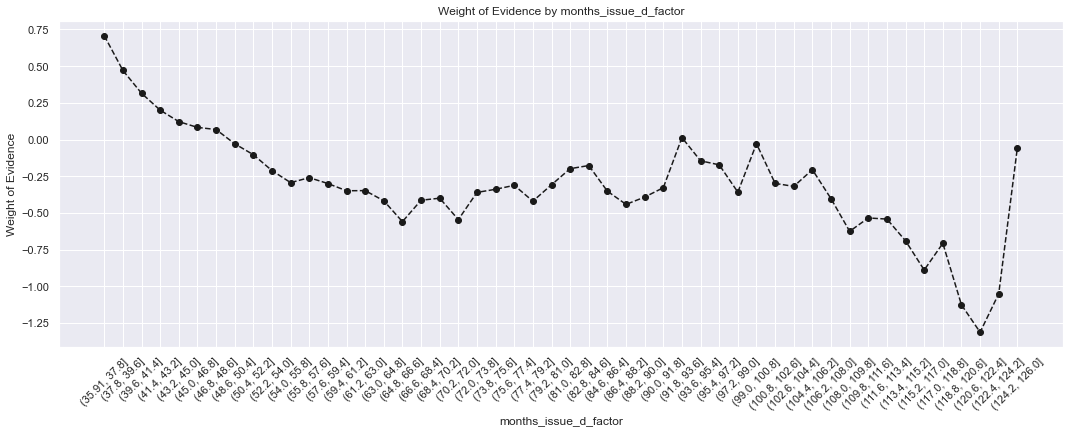

In [109]:
issue = IV_calculation_single(loan_data,'months_issue_d_factor', 'good_bad', sort=False)
plot_by_woe(issue, 45)
issue

In [106]:
loan_data['mths_issue_d <38'] = np.where(loan_data['months_issue_d'].isin(range(38)), 1, 0)
loan_data['mths_issue_d 38-39'] = np.where(loan_data['months_issue_d'].isin(range(38, 40)), 1, 0)
loan_data['mths_issue_d 40-41'] = np.where(loan_data['months_issue_d'].isin(range(40, 42)), 1, 0)
loan_data['mths_issue_d 42-48'] = np.where(loan_data['months_issue_d'].isin(range(42, 49)), 1, 0)
loan_data['mths_issue_d 49-52'] = np.where(loan_data['months_issue_d'].isin(range(49, 53)), 1, 0)
loan_data['mths_issue_d 53-64'] = np.where(loan_data['months_issue_d'].isin(range(53, 65)), 1, 0)
loan_data['mths_issue_d 65-84'] = np.where(loan_data['months_issue_d'].isin(range(65, 85)), 1, 0)
loan_data['mths_issue_d >84'] = np.where(loan_data['months_issue_d'].isin(range(85, int(loan_data['months_issue_d'].max()))), 1, 0)

In [108]:
loan_data['int_rate_factor'] = pd.cut(loan_data['int_rate'], 40)

good_bad,Bad,Good,Portion Good(1),Portion Bad(0),WoE,Good-Bad,IV
int_rate_factor,,,,,,,
"(5.399, 5.936]",36,947,0.002280,0.000706,1.171936,0.001574,0.342627
"(5.936, 6.452]",209,10394,0.025027,0.004101,1.808806,0.020926,0.342627
"(6.452, 6.968]",310,10114,0.024352,0.006082,1.387259,0.018270,0.342627
"(6.968, 7.484]",128,5430,0.013074,0.002511,1.649820,0.010563,0.342627
"(7.484, 8.0]",1160,24957,0.060091,0.022759,0.970890,0.037332,0.342627
"(8.0, 8.516]",262,7661,0.018446,0.005140,1.277709,0.013306,0.342627
"(8.516, 9.032]",794,13290,0.032000,0.015578,0.719840,0.016421,0.342627
"(9.032, 9.548]",280,8006,0.019277,0.005494,1.255313,0.013783,0.342627
"(9.548, 10.064]",812,10851,0.026127,0.015932,0.494668,0.010195,0.342627


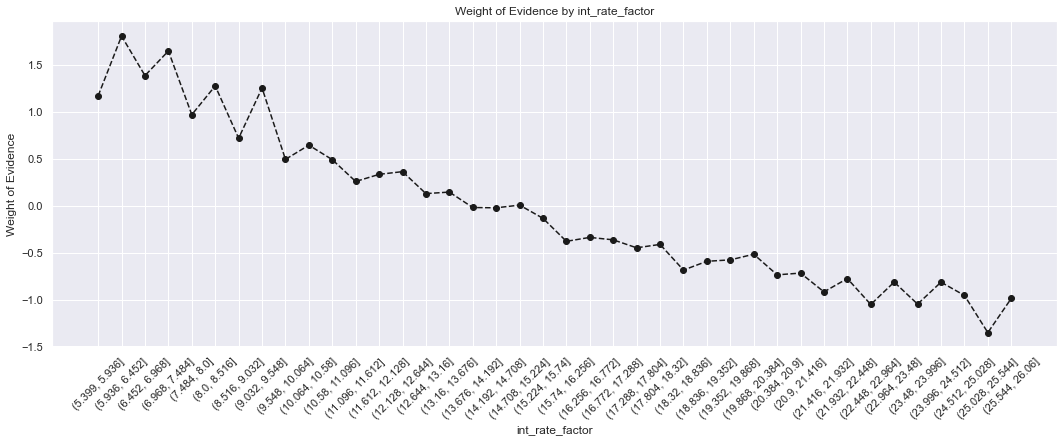

In [110]:
interest = IV_calculation_single(loan_data,'int_rate_factor', 'good_bad', sort=False)
plot_by_woe(interest, 45)
interest

In [111]:
loan_data['int_rate <9.548'] = np.where((loan_data['int_rate'] <= 9.548), 1, 0)
loan_data['int_rate 9.548-12.025'] = np.where((loan_data['int_rate'] > 9.548) & (loan_data['int_rate'] <= 12.025), 1, 0)
loan_data['int_rate 12.025-15.74'] = np.where((loan_data['int_rate'] > 12.025) & (loan_data['int_rate'] <= 15.74), 1, 0)
loan_data['int_rate 15.74-20.281'] = np.where((loan_data['int_rate'] > 15.74) & (loan_data['int_rate'] <= 20.281), 1, 0)
loan_data['int_rate >20.281'] = np.where((loan_data['int_rate'] > 20.281), 1, 0)

good_bad,Bad,Good,Portion Good(1),Portion Bad(0),WoE,Good-Bad,IV
funded_amnt_factor,,,,,,,
"(465.5, 1362.5]",246,2228,0.005365,0.004827,0.105684,0.000538,0.009753
"(1362.5, 2225.0]",701,6038,0.014538,0.013754,0.055476,0.000785,0.009753
"(2225.0, 3087.5]",1189,10018,0.024121,0.023328,0.033427,0.000793,0.009753
"(3087.5, 3950.0]",829,6714,0.016166,0.016265,-0.006114,-0.000099,0.009753
"(3950.0, 4812.5]",1628,12898,0.031056,0.031942,-0.028124,-0.000886,0.009753
"(4812.5, 5675.0]",2325,19981,0.048110,0.045617,0.053218,0.002493,0.009753
"(5675.0, 6537.5]",2229,20566,0.049519,0.043733,0.124242,0.005785,0.009753
"(6537.5, 7400.0]",1690,14604,0.035164,0.033158,0.058723,0.002005,0.009753
"(7400.0, 8262.5]",2376,20614,0.049634,0.046617,0.062708,0.003017,0.009753


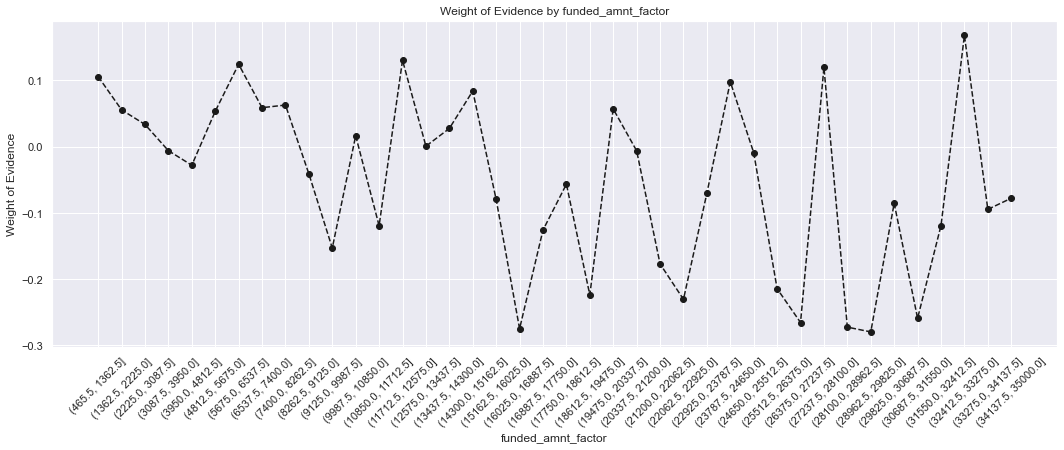

In [113]:
loan_data['funded_amnt_factor'] = pd.cut(loan_data['funded_amnt'], 40)
amnt = IV_calculation_single(loan_data,'funded_amnt_factor', 'good_bad', sort=False)
plot_by_woe(amnt, 45)
amnt

 <font color=green> __There is no clear pattern here nor strong relationship. We will NOT use this variable in our PD model__</font>

good_bad,Bad,Good,Portion Good(1),Portion Bad(0),WoE,Good-Bad,IV
mths_since_earliest_cr_line_factor,,,,,,,
"(-0.587, 14.675]",3,26,0.000063,0.000059,0.061640,0.000004,inf
"(58.7, 73.375]",0,3,0.000007,0.000000,inf,0.000007,inf
"(73.375, 88.05]",217,2043,0.004919,0.004258,0.144433,0.000662,inf
"(88.05, 102.725]",520,3241,0.007804,0.010202,-0.268036,-0.002399,inf
"(102.725, 117.4]",964,6245,0.015037,0.018914,-0.229399,-0.003877,inf
"(117.4, 132.075]",2041,12842,0.030921,0.040045,-0.258563,-0.009124,inf
"(132.075, 146.75]",2474,16805,0.040463,0.048540,-0.182004,-0.008077,inf
"(146.75, 161.425]",2891,21284,0.051248,0.056722,-0.101491,-0.005474,inf
"(161.425, 176.1]",3403,25745,0.061989,0.066767,-0.074261,-0.004779,inf


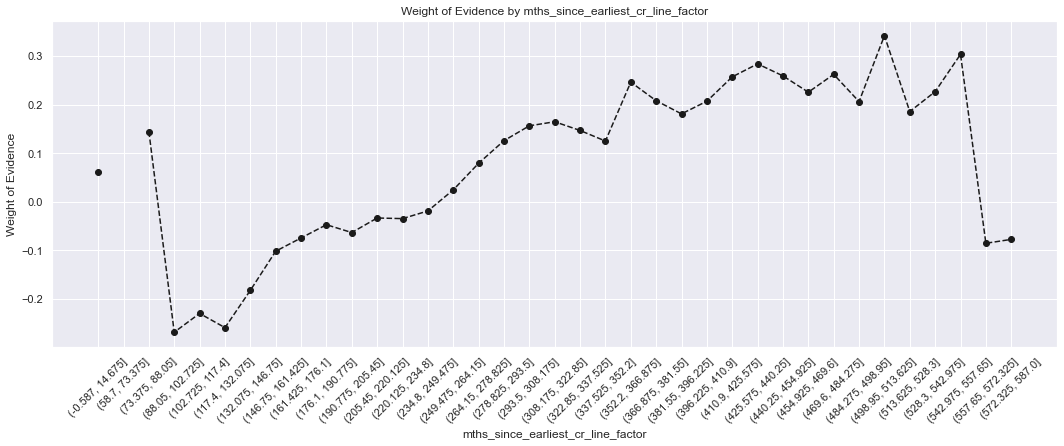

In [115]:
loan_data['mths_since_earliest_cr_line_factor'] = pd.cut(loan_data['mths_since_earliest_cr_line'], 40)
early = IV_calculation_single(loan_data,'mths_since_earliest_cr_line_factor', 'good_bad', sort=False)
plot_by_woe(early, 45)
early

In [116]:
loan_data['mths_since_earliest_cr_line <140'] = np.where(loan_data['mths_since_earliest_cr_line'].isin(range(140)), 1, 0)
loan_data['mths_since_earliest_cr_line 141-164'] = np.where(loan_data['mths_since_earliest_cr_line'].isin(range(140, 165)), 1, 0)
loan_data['mths_since_earliest_cr_line 165-247'] = np.where(loan_data['mths_since_earliest_cr_line'].isin(range(165, 248)), 1, 0)
loan_data['mths_since_earliest_cr_line 248-270'] = np.where(loan_data['mths_since_earliest_cr_line'].isin(range(248, 271)), 1, 0)
loan_data['mths_since_earliest_cr_line 271-352'] = np.where(loan_data['mths_since_earliest_cr_line'].isin(range(271, 353)), 1, 0)
loan_data['mths_since_earliest_cr_line >352'] = np.where(loan_data['mths_since_earliest_cr_line'].isin(range(353, int(loan_data['mths_since_earliest_cr_line'].max()))), 1, 0)

good_bad,Bad,Good,Portion Good(1),Portion Bad(0),WoE,Good-Bad,IV
delinq_2yrs,,,,,,,
0.0,41903,341080,0.821252,0.822143,-0.001084,-0.000891,inf
1.0,6034,50190,0.120847,0.118388,0.020562,0.002459,inf
2.0,1823,14487,0.034882,0.035768,-0.025076,-0.000886,inf
3.0,652,5032,0.012116,0.012792,-0.054316,-0.000676,inf
4.0,247,2131,0.005131,0.004846,0.057114,0.000285,inf
5.0,138,1098,0.002644,0.002708,-0.023852,-0.000064,inf
6.0,67,562,0.001353,0.001315,0.028965,0.000039,inf
7.0,44,302,0.000727,0.000863,-0.171607,-0.000136,inf
8.0,17,160,0.000385,0.000334,0.144116,0.000052,inf


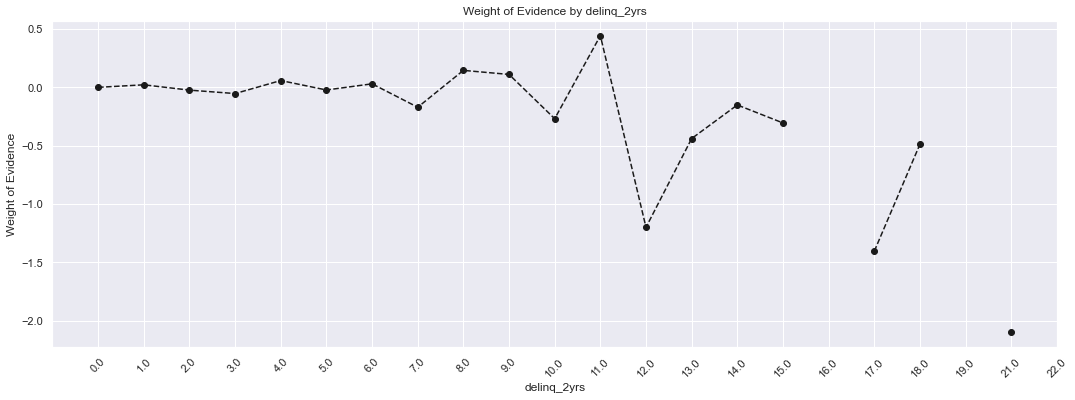

In [117]:
delinq = IV_calculation_single(loan_data,'delinq_2yrs', 'good_bad', sort=False)
plot_by_woe(delinq, 45)
delinq

In [118]:
loan_data['delinq_2yrs 0'] = np.where((loan_data['delinq_2yrs'] == 0), 1, 0)
loan_data['delinq_2yrs 1-3'] = np.where((loan_data['delinq_2yrs'] >= 1) & (loan_data['delinq_2yrs'] <= 3), 1, 0)
loan_data['delinq_2yrs >=4'] = np.where((loan_data['delinq_2yrs'] >= 9), 1, 0)

/Users/graystone/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


good_bad,Bad,Good,Portion Good(1),Portion Bad(0),WoE,Good-Bad,IV
inq_last_6mths,,,,,,,
0.0,22043,219484,0.528473,0.432487,0.200440,0.095986,inf
1.0,15040,115108,0.277157,0.295087,-0.062687,-0.017930,inf
2.0,7887,49938,0.120241,0.154744,-0.252278,-0.034503,inf
3.0,3995,21131,0.050879,0.078383,-0.432147,-0.027503,inf
4.0,1108,6133,0.014767,0.021739,-0.386717,-0.006972,inf
5.0,475,2293,0.005521,0.009320,-0.523543,-0.003798,inf
6.0,257,931,0.002242,0.005042,-0.810661,-0.002801,inf
7.0,68,127,0.000306,0.001334,-1.473165,-0.001028,inf
8.0,46,76,0.000183,0.000903,-1.595752,-0.000720,inf


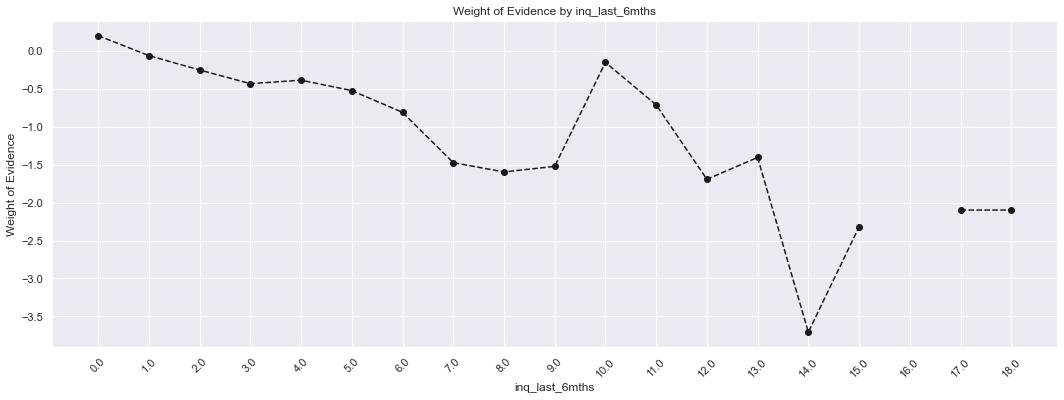

In [119]:
inq = IV_calculation_single(loan_data,'inq_last_6mths', 'good_bad', sort=False)
plot_by_woe(inq, 45)
inq

In [120]:
loan_data['inq_last_6mths 0'] = np.where((loan_data['inq_last_6mths'] == 0), 1, 0)
loan_data['inq_last_6mths 1-2'] = np.where((loan_data['inq_last_6mths'] >= 1) & (loan_data['inq_last_6mths'] <= 2), 1, 0)
loan_data['inq_last_6mths 3-6'] = np.where((loan_data['inq_last_6mths'] >= 3) & (loan_data['inq_last_6mths'] <= 6), 1, 0)
loan_data['inq_last_6mths >6'] = np.where((loan_data['inq_last_6mths'] > 6), 1, 0)

/Users/graystone/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


good_bad,Bad,Good,Portion Good(1),Portion Bad(0),WoE,Good-Bad,IV
open_acc,,,,,,,
0.0,7,29,0.000070,0.000137,-0.676458,-0.000068,inf
1.0,18,124,0.000299,0.000353,-0.167934,-0.000055,inf
2.0,279,1511,0.003638,0.005474,-0.408529,-0.001836,inf
3.0,718,4782,0.011514,0.014087,-0.201700,-0.002573,inf
4.0,1364,11224,0.027025,0.026762,0.009789,0.000263,inf
...,...,...,...,...,...,...,...
61.0,0,1,0.000002,0.000000,inf,0.000002,inf
62.0,0,1,0.000002,0.000000,inf,0.000002,inf
75.0,0,1,0.000002,0.000000,inf,0.000002,inf


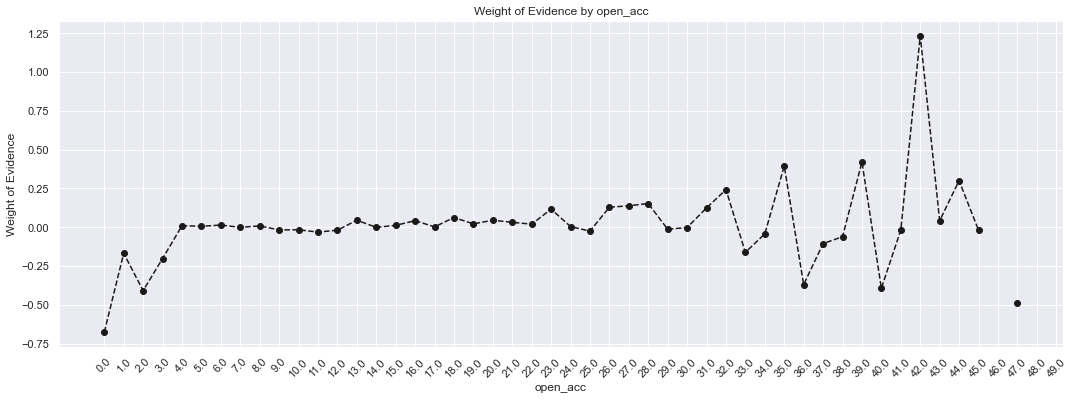

In [121]:
acc = IV_calculation_single(loan_data,'open_acc', 'good_bad', sort=False)
plot_by_woe(acc, 45)
acc

In [122]:
loan_data['open_acc 0'] = np.where((loan_data['open_acc'] == 0), 1, 0)
loan_data['open_acc 1-3'] = np.where((loan_data['open_acc'] >= 1) & (loan_data['open_acc'] <= 3), 1, 0)
loan_data['open_acc 4-12'] = np.where((loan_data['open_acc'] >= 4) & (loan_data['open_acc'] <= 12), 1, 0)
loan_data['open_acc 13-17'] = np.where((loan_data['open_acc'] >= 13) & (loan_data['open_acc'] <= 17), 1, 0)
loan_data['open_acc 18-22'] = np.where((loan_data['open_acc'] >= 18) & (loan_data['open_acc'] <= 22), 1, 0)
loan_data['open_acc 23-25'] = np.where((loan_data['open_acc'] >= 23) & (loan_data['open_acc'] <= 25), 1, 0)
loan_data['open_acc 26-30'] = np.where((loan_data['open_acc'] >= 26) & (loan_data['open_acc'] <= 30), 1, 0)
loan_data['open_acc >=31'] = np.where((loan_data['open_acc'] >= 31), 1, 0)

good_bad,Bad,Good,Portion Good(1),Portion Bad(0),WoE,Good-Bad,IV
pub_rec,,,,,,,
0.0,44627,360295,0.867518,0.875589,-0.009260,-0.008071,inf
1.0,5572,47479,0.114320,0.109323,0.044689,0.004996,inf
2.0,543,5081,0.012234,0.010654,0.138310,0.001580,inf
3.0,135,1476,0.003554,0.002649,0.293972,0.000905,inf
4.0,47,473,0.001139,0.000922,0.211104,0.000217,inf
5.0,25,251,0.000604,0.000491,0.208733,0.000114,inf
6.0,10,126,0.000303,0.000196,0.435853,0.000107,inf
7.0,5,57,0.000137,0.000098,0.335769,0.000039,inf
8.0,1,28,0.000067,0.000020,1.234360,0.000048,inf


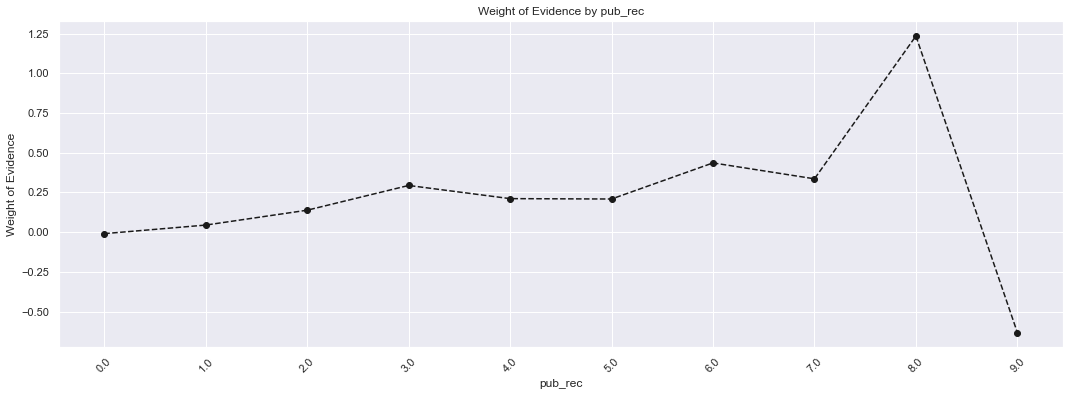

In [123]:
pub = IV_calculation_single(loan_data,'pub_rec', 'good_bad', sort=False)
plot_by_woe(pub, 45)
pub

In [124]:
loan_data['pub_rec 0-2'] = np.where((loan_data['pub_rec'] >= 0) & (loan_data['pub_rec'] <= 2), 1, 0)
loan_data['pub_rec 3-4'] = np.where((loan_data['pub_rec'] >= 3) & (loan_data['pub_rec'] <= 4), 1, 0)
loan_data['pub_rec >=5'] = np.where((loan_data['pub_rec'] >= 5), 1, 0)

good_bad,Bad,Good,Portion Good(1),Portion Bad(0),WoE,Good-Bad,IV
total_acc_factor,,,,,,,
"(-0.156, 3.12]",115,469,0.001129,0.002256,-0.692173,-1.127060e-03,inf
"(3.12, 6.24]",1036,6467,0.015571,0.020326,-0.266499,-4.755241e-03,inf
"(6.24, 9.36]",2385,16377,0.039433,0.046794,-0.171165,-7.361537e-03,inf
"(9.36, 12.48]",3775,27682,0.066653,0.074066,-0.105462,-7.413379e-03,inf
"(12.48, 15.6]",4921,37019,0.089134,0.096551,-0.079925,-7.416453e-03,inf
"(15.6, 18.72]",5445,43109,0.103798,0.106832,-0.028810,-3.033916e-03,inf
"(18.72, 21.84]",5712,45157,0.108729,0.112070,-0.030268,-3.341324e-03,inf
"(21.84, 24.96]",5427,44707,0.107645,0.106479,0.010899,1.166910e-03,inf
"(24.96, 28.08]",6199,53030,0.127686,0.121625,0.048626,6.060266e-03,inf


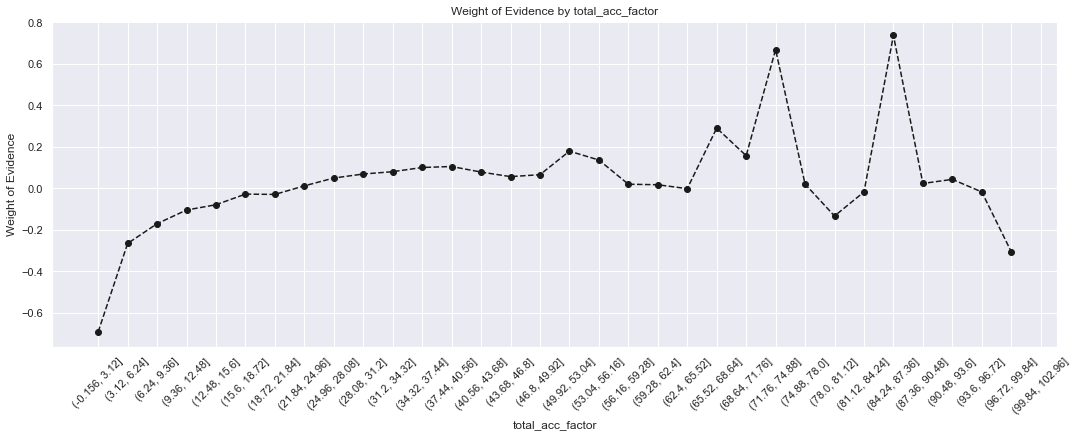

In [125]:
loan_data['total_acc_factor'] = pd.cut(loan_data['total_acc'], 50)
total_acc = IV_calculation_single(loan_data,'total_acc_factor', 'good_bad', sort=False)
plot_by_woe(total_acc, 45)
total_acc

In [126]:
loan_data['total_acc <=27'] = np.where((loan_data['total_acc'] <= 27), 1, 0)
loan_data['total_acc 28-51'] = np.where((loan_data['total_acc'] >= 28) & (loan_data['total_acc'] <= 51), 1, 0)
loan_data['total_acc >=52'] = np.where((loan_data['total_acc'] >= 52), 1, 0)

good_bad,Bad,Good,Portion Good(1),Portion Bad(0),WoE,Good-Bad,IV
acc_now_delinq,,,,,,,
0.0,50783,413770,0.996275,0.996370,-0.000095,-0.000095,inf
1.0,173,1450,0.003491,0.003394,0.028183,0.000097,inf
2.0,9,83,0.000200,0.000177,0.123772,0.000023,inf
3.0,2,9,0.000022,0.000039,-0.593767,-0.000018,inf
4.0,0,4,0.000010,0.000000,inf,0.000010,inf
5.0,1,1,0.000002,0.000020,-2.097844,-0.000017,inf


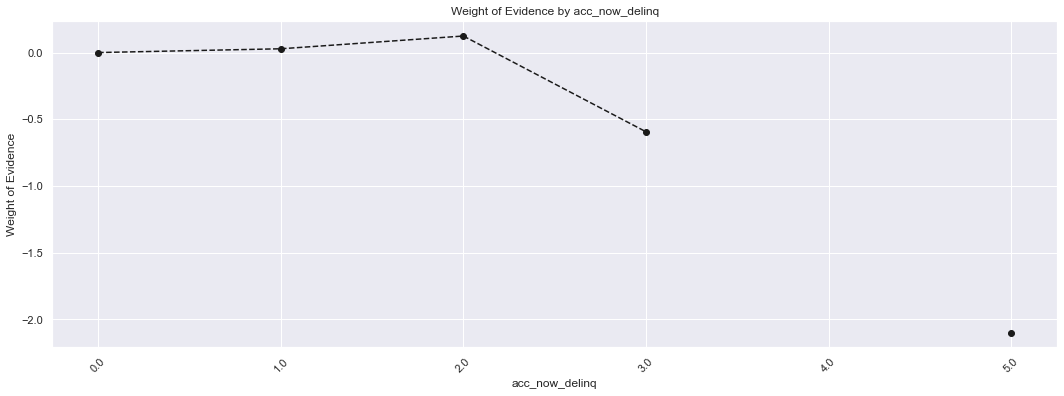

In [127]:
acc_now = IV_calculation_single(loan_data,'acc_now_delinq', 'good_bad', sort=False)
plot_by_woe(acc_now, 45)
acc_now

In [128]:
loan_data['acc_now_delinq 0'] = np.where((loan_data['acc_now_delinq'] == 0), 1, 0)
loan_data['acc_now_delinq >=1'] = np.where((loan_data['acc_now_delinq'] >= 1), 1, 0)

/Users/graystone/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


good_bad,Bad,Good,Portion Good(1),Portion Bad(0),WoE,Good-Bad,IV
total_rev_hi_lim_factor,,,,,,,
"(-9999.999, 5000.0]",3274,21039,0.050658,0.064236,-0.237479,-0.013579,inf
"(5000.0, 9999.999]",8205,57733,0.139009,0.160983,-0.146759,-0.021974,inf
"(9999.999, 14999.998]",8900,65457,0.157607,0.174619,-0.102502,-0.017012,inf
"(14999.998, 19999.998]",7833,56426,0.135862,0.153685,-0.123260,-0.017822,inf
"(19999.998, 24999.997]",5883,46112,0.111028,0.115425,-0.038838,-0.004397,inf
...,...,...,...,...,...,...,...
"(1309999.869, 1314999.868]",0,1,0.000002,0.000000,inf,0.000002,inf
"(1504999.85, 1509999.849]",0,1,0.000002,0.000000,inf,0.000002,inf
"(1994999.8, 1999999.8]",1,0,0.000000,0.000020,-inf,-0.000020,inf


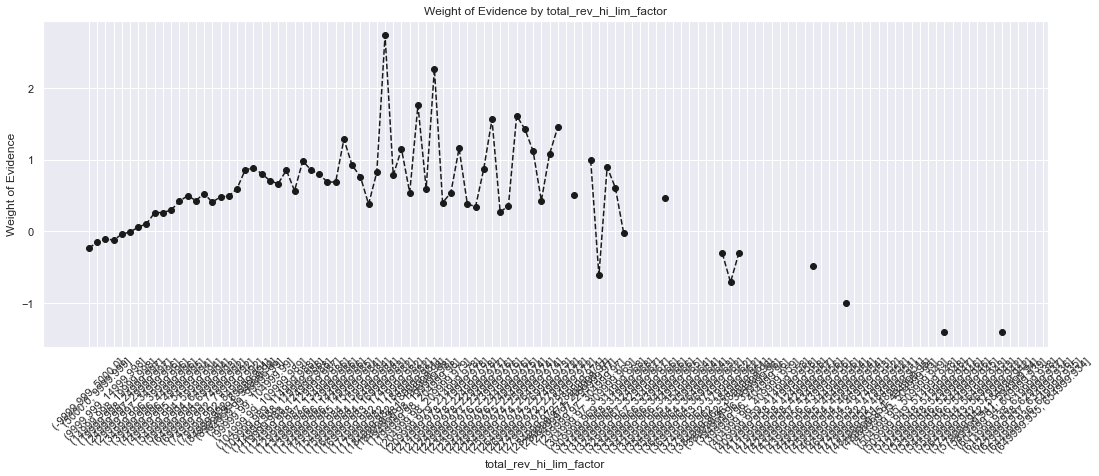

In [129]:
loan_data['total_rev_hi_lim_factor'] = pd.cut(loan_data['total_rev_hi_lim'], 2000)
total_rev = IV_calculation_single(loan_data,'total_rev_hi_lim_factor', 'good_bad', sort=False)
plot_by_woe(total_rev, 45)
total_rev

In [130]:
loan_data['total_rev_hi_lim <=5K'] = np.where((loan_data['total_rev_hi_lim'] <= 5000), 1, 0)
loan_data['total_rev_hi_lim 5K-10K'] = np.where((loan_data['total_rev_hi_lim'] > 5000) & (loan_data['total_rev_hi_lim'] <= 10000), 1, 0)
loan_data['total_rev_hi_lim 10K-20K'] = np.where((loan_data['total_rev_hi_lim'] > 10000) & (loan_data['total_rev_hi_lim'] <= 20000), 1, 0)
loan_data['total_rev_hi_lim 20K-30K'] = np.where((loan_data['total_rev_hi_lim'] > 20000) & (loan_data['total_rev_hi_lim'] <= 30000), 1, 0)
loan_data['total_rev_hi_lim 30K-40K'] = np.where((loan_data['total_rev_hi_lim'] > 30000) & (loan_data['total_rev_hi_lim'] <= 40000), 1, 0)
loan_data['total_rev_hi_lim 40K-55K'] = np.where((loan_data['total_rev_hi_lim'] > 40000) & (loan_data['total_rev_hi_lim'] <= 55000), 1, 0)
loan_data['total_rev_hi_lim 55K-95K'] = np.where((loan_data['total_rev_hi_lim'] > 55000) & (loan_data['total_rev_hi_lim'] <= 95000), 1, 0)
loan_data['total_rev_hi_lim >95K'] = np.where((loan_data['total_rev_hi_lim'] > 95000), 1, 0)

good_bad,Bad,Good,Portion Good(1),Portion Bad(0),WoE,Good-Bad,IV
installment_factor,,,,,,,
"(14.276, 43.556]",232,2065,0.004972,0.004552,0.088304,0.000420,0.013297
"(43.556, 71.443]",616,5474,0.013180,0.012086,0.086674,0.001094,0.013297
"(71.443, 99.329]",910,7644,0.018405,0.017854,0.030388,0.000551,0.013297
"(99.329, 127.216]",1242,10198,0.024555,0.024368,0.007625,0.000187,0.013297
"(127.216, 155.102]",1335,11313,0.027239,0.026193,0.039177,0.001047,0.013297
"(155.102, 182.988]",2202,18751,0.045149,0.043204,0.044037,0.001945,0.013297
"(182.988, 210.875]",2031,19311,0.046497,0.039849,0.154302,0.006648,0.013297
"(210.875, 238.761]",1869,16935,0.040776,0.036670,0.106135,0.004106,0.013297
"(238.761, 266.648]",2329,21203,0.051053,0.045695,0.110860,0.005357,0.013297


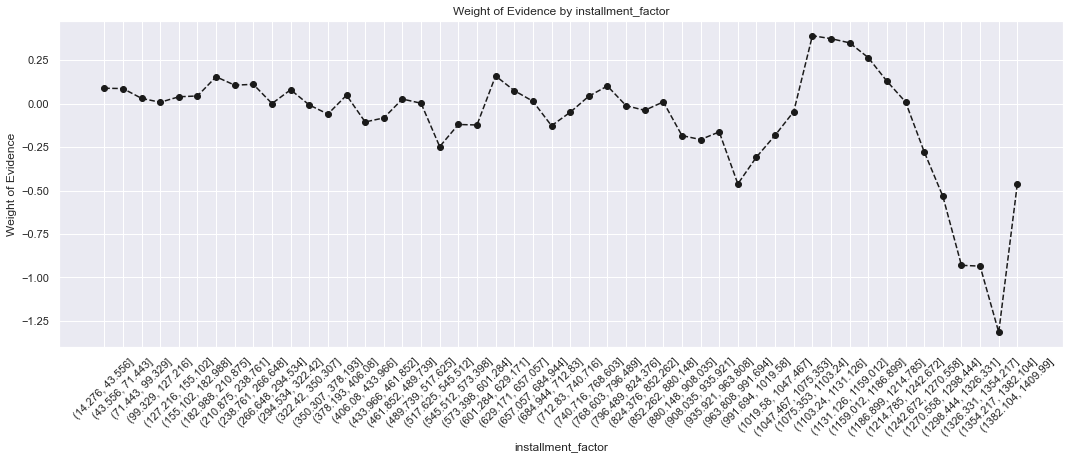

In [131]:
loan_data['installment_factor'] = pd.cut(loan_data['installment'], 50)
installment = IV_calculation_single(loan_data,'installment_factor', 'good_bad', sort=False)
plot_by_woe(installment, 45)
installment

good_bad,Bad,Good,Portion Good(1),Portion Bad(0),WoE,Good-Bad,IV
annual_inc_factor,,,,,,,
"(-5602.104, 76877.04]",37583,268860,0.647361,0.737384,-0.130205,-9.002331e-02,inf
"(76877.04, 151858.08]",11906,127494,0.306980,0.233598,0.273183,7.338242e-02,inf
"(151858.08, 226839.12]",1087,13779,0.033177,0.021327,0.441880,1.184996e-02,inf
"(226839.12, 301820.16]",259,3300,0.007946,0.005082,0.447006,2.864118e-03,inf
"(301820.16, 376801.2]",61,806,0.001941,0.001197,0.483366,7.438569e-04,inf
"(376801.2, 451782.24]",30,471,0.001134,0.000589,0.655817,5.454689e-04,inf
"(451782.24, 526763.28]",11,221,0.000532,0.000216,0.902423,3.163020e-04,inf
"(526763.28, 601744.32]",11,129,0.000311,0.000216,0.364073,9.478442e-05,inf
"(601744.32, 676725.36]",6,49,0.000118,0.000118,0.002217,2.612449e-07,inf


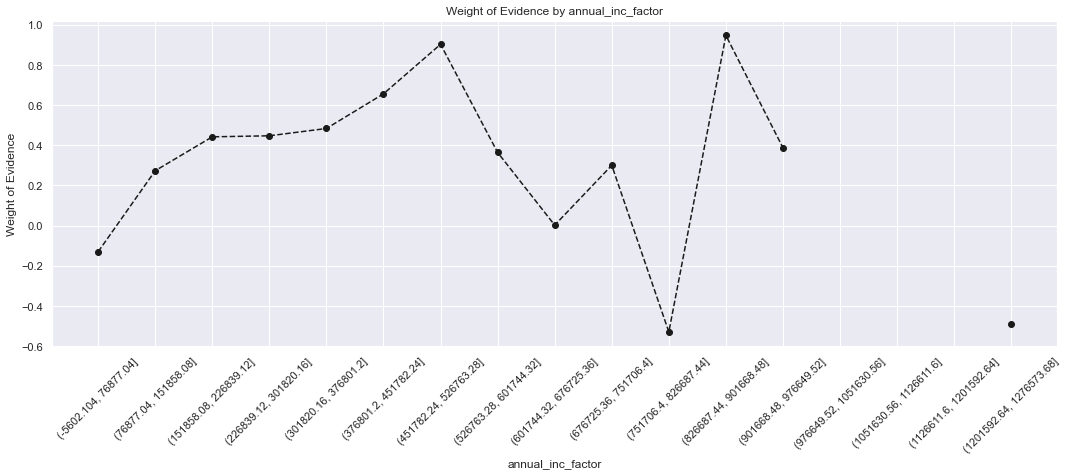

In [132]:
loan_data['annual_inc_factor'] = pd.cut(loan_data['annual_inc'], 100)
income = IV_calculation_single(loan_data,'annual_inc_factor', 'good_bad', sort=False)
plot_by_woe(income, 45)
income

good_bad,Bad,Good,Portion Good(1),Portion Bad(0),WoE,Good-Bad,IV
annual_inc_factor,,,,,,,
"(1757.896, 3277.04]",1,2,0.000005,0.000020,-1.382316,-0.000015,0.051132
"(3277.04, 4658.08]",2,10,0.000026,0.000041,-0.466025,-0.000015,0.051132
"(4658.08, 6039.12]",5,21,0.000054,0.000102,-0.640379,-0.000048,0.051132
"(6039.12, 7420.16]",5,15,0.000038,0.000102,-0.976851,-0.000064,0.051132
"(7420.16, 8801.2]",13,94,0.000241,0.000266,-0.097118,-0.000025,0.051132
...,...,...,...,...,...,...,...
"(133094.8, 134475.84]",19,250,0.000641,0.000388,0.501559,0.000253,0.051132
"(134475.84, 135856.88]",111,1701,0.004363,0.002269,0.653978,0.002095,0.051132
"(135856.88, 137237.92]",36,506,0.001298,0.000736,0.567555,0.000562,0.051132


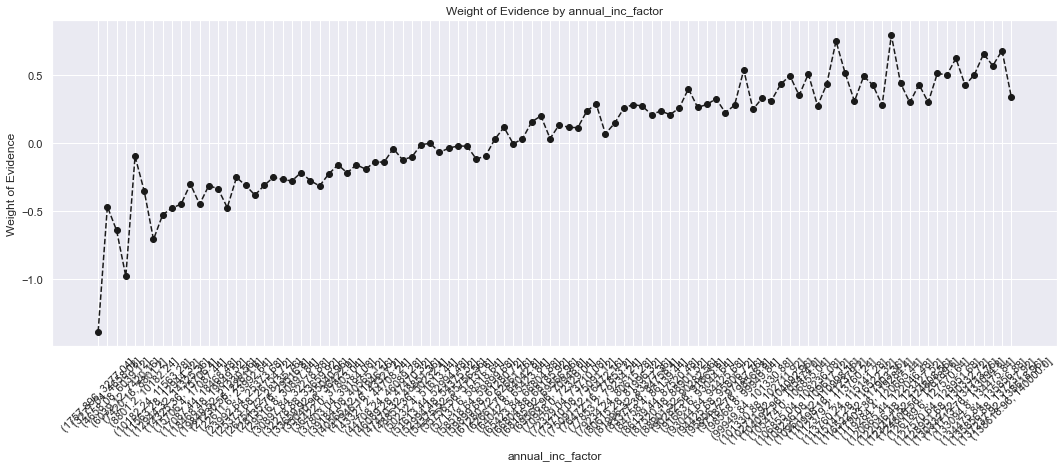

In [134]:
loan_data['annual_inc_factor'] = pd.cut(loan_data['annual_inc'][loan_data['annual_inc'] <= 140000], 100)
income = IV_calculation_single(loan_data,'annual_inc_factor', 'good_bad', sort=False)
plot_by_woe(income, 45)
income

In [135]:
loan_data['annual_inc <20K'] = np.where((loan_data['annual_inc'] <= 20000), 1, 0)
loan_data['annual_inc 20K-30K'] = np.where((loan_data['annual_inc'] > 20000) & (loan_data['annual_inc'] <= 30000), 1, 0)
loan_data['annual_inc 30K-40K'] = np.where((loan_data['annual_inc'] > 30000) & (loan_data['annual_inc'] <= 40000), 1, 0)
loan_data['annual_inc 40K-50K'] = np.where((loan_data['annual_inc'] > 40000) & (loan_data['annual_inc'] <= 50000), 1, 0)
loan_data['annual_inc 50K-60K'] = np.where((loan_data['annual_inc'] > 50000) & (loan_data['annual_inc'] <= 60000), 1, 0)
loan_data['annual_inc 60K-70K'] = np.where((loan_data['annual_inc'] > 60000) & (loan_data['annual_inc'] <= 70000), 1, 0)
loan_data['annual_inc 70K-80K'] = np.where((loan_data['annual_inc'] > 70000) & (loan_data['annual_inc'] <= 80000), 1, 0)
loan_data['annual_inc 80K-90K'] = np.where((loan_data['annual_inc'] > 80000) & (loan_data['annual_inc'] <= 90000), 1, 0)
loan_data['annual_inc 90K-100K'] = np.where((loan_data['annual_inc'] > 90000) & (loan_data['annual_inc'] <= 100000), 1, 0)
loan_data['annual_inc 100K-120K'] = np.where((loan_data['annual_inc'] > 100000) & (loan_data['annual_inc'] <= 120000), 1, 0)
loan_data['annual_inc 120K-140K'] = np.where((loan_data['annual_inc'] > 120000) & (loan_data['annual_inc'] <= 140000), 1, 0)
loan_data['annual_inc >140K'] = np.where((loan_data['annual_inc'] > 140000), 1, 0)

good_bad,Bad,Good,Portion Good(1),Portion Bad(0),WoE,Good-Bad,IV
mths_since_last_delinq_factor,,,,,,,
"(-0.188, 3.76]",855,5770,0.029951,0.036720,-0.203783,-0.006770,inf
"(3.76, 7.52]",1566,12268,0.063680,0.067256,-0.054639,-0.003576,inf
"(7.52, 11.28]",1797,14893,0.077306,0.077177,0.001664,0.000129,inf
"(11.28, 15.04]",1852,14695,0.076278,0.079540,-0.041867,-0.003261,inf
"(15.04, 18.8]",1225,10420,0.054088,0.052611,0.027678,0.001476,inf
"(18.8, 22.56]",1560,13019,0.067579,0.066999,0.008615,0.000580,inf
"(22.56, 26.32]",1414,12189,0.063270,0.060728,0.041003,0.002542,inf
"(26.32, 30.08]",1384,11837,0.061443,0.059440,0.033144,0.002003,inf
"(30.08, 33.84]",949,8493,0.044085,0.040758,0.078480,0.003328,inf


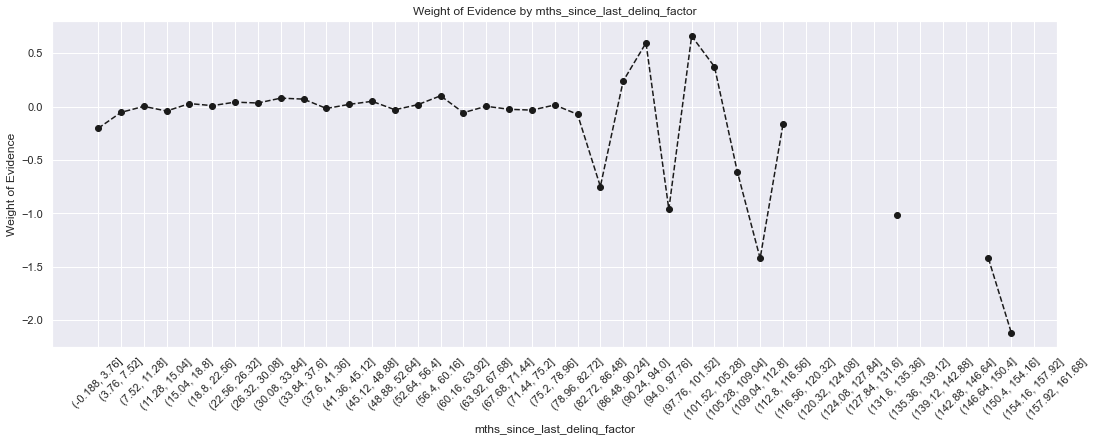

In [137]:
loan_data['mths_since_last_delinq_factor'] = pd.cut(loan_data['mths_since_last_delinq'][pd.notnull(loan_data['mths_since_last_delinq'])], 50)
last_delinq = IV_calculation_single(loan_data,'mths_since_last_delinq_factor', 'good_bad', sort=False)
plot_by_woe(last_delinq, 45)
last_delinq

In [138]:
loan_data['mths_since_last_delinq Missing'] = np.where((loan_data['mths_since_last_delinq'].isnull()), 1, 0)
loan_data['mths_since_last_delinq 0-3'] = np.where((loan_data['mths_since_last_delinq'] >= 0) & (loan_data['mths_since_last_delinq'] <= 3), 1, 0)
loan_data['mths_since_last_delinq 4-30'] = np.where((loan_data['mths_since_last_delinq'] >= 4) & (loan_data['mths_since_last_delinq'] <= 30), 1, 0)
loan_data['mths_since_last_delinq 31-56'] = np.where((loan_data['mths_since_last_delinq'] >= 31) & (loan_data['mths_since_last_delinq'] <= 56), 1, 0)
loan_data['mths_since_last_delinq >=57'] = np.where((loan_data['mths_since_last_delinq'] >= 57), 1, 0)

good_bad,Bad,Good,Portion Good(1),Portion Bad(0),WoE,Good-Bad,IV
dti_factor,,,,,,,
"(-0.04, 0.8]",199,1725,0.004153,0.003904,0.061833,0.000249,0.027154
"(0.8, 1.6]",251,2192,0.005278,0.004925,0.069273,0.000353,0.027154
"(1.6, 2.399]",287,2861,0.006889,0.005631,0.201600,0.001258,0.027154
"(2.399, 3.199]",362,3680,0.008861,0.007102,0.221180,0.001758,0.027154
"(3.199, 3.999]",467,4704,0.011326,0.009163,0.211995,0.002164,0.027154
"(3.999, 4.799]",527,5770,0.013893,0.010340,0.295383,0.003553,0.027154
"(4.799, 5.599]",662,6854,0.016503,0.012989,0.239478,0.003515,0.027154
"(5.599, 6.398]",741,7770,0.018709,0.014539,0.252181,0.004170,0.027154
"(6.398, 7.198]",824,8840,0.021285,0.016167,0.275028,0.005118,0.027154


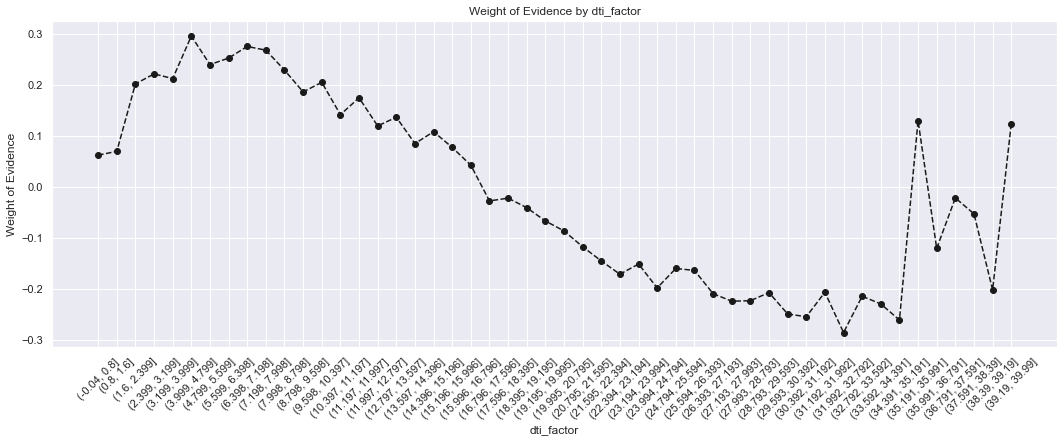

In [143]:
loan_data['dti_factor'] = pd.cut(loan_data['dti'], 50)
dti = IV_calculation_single(loan_data,'dti_factor', 'good_bad', sort=False)
plot_by_woe(dti, 45)
dti

In [140]:
loan_data['dti <=1.4'] = np.where((loan_data['dti'] <= 1.4), 1, 0)
loan_data['dti 1.4-3.5'] = np.where((loan_data['dti'] > 1.4) & (loan_data['dti'] <= 3.5), 1, 0)
loan_data['dti 3.5-7.7'] = np.where((loan_data['dti'] > 3.5) & (loan_data['dti'] <= 7.7), 1, 0)
loan_data['dti 7.7-10.5'] = np.where((loan_data['dti'] > 7.7) & (loan_data['dti'] <= 10.5), 1, 0)
loan_data['dti 10.5-16.1'] = np.where((loan_data['dti'] > 10.5) & (loan_data['dti'] <= 16.1), 1, 0)
loan_data['dti 16.1-20.3'] = np.where((loan_data['dti'] > 16.1) & (loan_data['dti'] <= 20.3), 1, 0)
loan_data['dti 20.3-21.7'] = np.where((loan_data['dti'] > 20.3) & (loan_data['dti'] <= 21.7), 1, 0)
loan_data['dti 21.7-22.4'] = np.where((loan_data['dti'] > 21.7) & (loan_data['dti'] <= 22.4), 1, 0)
loan_data['dti 22.4-35'] = np.where((loan_data['dti'] > 22.4) & (loan_data['dti'] <= 35), 1, 0)
loan_data['dti >35'] = np.where((loan_data['dti'] > 35), 1, 0)

/Users/graystone/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


good_bad,Bad,Good,Portion Good(1),Portion Bad(0),WoE,Good-Bad,IV
mths_since_last_record_factor,,,,,,,
"(-0.129, 2.58]",319,1011,0.018059,0.047941,-0.976344,-0.029882,inf
"(2.58, 5.16]",16,140,0.002501,0.002405,0.039206,0.000096,inf
"(5.16, 7.74]",13,145,0.002590,0.001954,0.281937,0.000636,inf
"(7.74, 10.32]",26,280,0.005001,0.003907,0.246845,0.001094,inf
"(10.32, 12.9]",27,223,0.003983,0.004058,-0.018513,-0.000074,inf
"(12.9, 15.48]",36,351,0.006270,0.005410,0.147420,0.000859,inf
"(15.48, 18.06]",38,381,0.006806,0.005711,0.175365,0.001095,inf
"(18.06, 20.64]",21,287,0.005126,0.003156,0.485112,0.001970,inf
"(20.64, 23.22]",51,501,0.008949,0.007665,0.154933,0.001284,inf


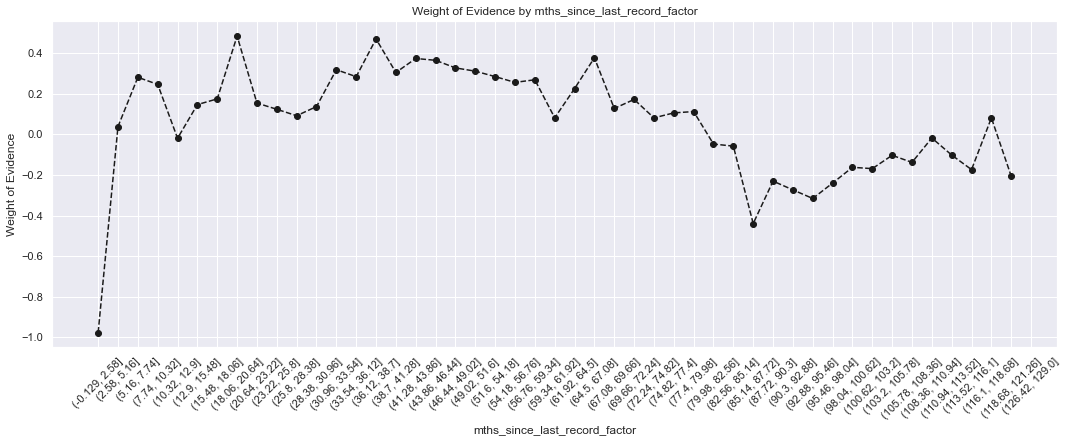

In [141]:
loan_data['mths_since_last_record_factor'] = pd.cut(loan_data['mths_since_last_record'][pd.notnull(loan_data['mths_since_last_record'])], 50)
last_rec = IV_calculation_single(loan_data,'mths_since_last_record_factor', 'good_bad', sort=False)
plot_by_woe(last_rec, 45)
last_rec

In [142]:
loan_data['mths_since_last_record Missing'] = np.where((loan_data['mths_since_last_record'].isnull()), 1, 0)
loan_data['mths_since_last_record 0-2'] = np.where((loan_data['mths_since_last_record'] >= 0) & (loan_data['mths_since_last_record'] <= 2), 1, 0)
loan_data['mths_since_last_record 3-20'] = np.where((loan_data['mths_since_last_record'] >= 3) & (loan_data['mths_since_last_record'] <= 20), 1, 0)
loan_data['mths_since_last_record 21-31'] = np.where((loan_data['mths_since_last_record'] >= 21) & (loan_data['mths_since_last_record'] <= 31), 1, 0)
loan_data['mths_since_last_record 32-80'] = np.where((loan_data['mths_since_last_record'] >= 32) & (loan_data['mths_since_last_record'] <= 80), 1, 0)
loan_data['mths_since_last_record 81-86'] = np.where((loan_data['mths_since_last_record'] >= 81) & (loan_data['mths_since_last_record'] <= 86), 1, 0)
loan_data['mths_since_last_record >=86'] = np.where((loan_data['mths_since_last_record'] >= 86), 1, 0)

### Split the dataset 

In [144]:
from sklearn.model_selection import train_test_split

In [152]:
loan_data_inputs_train, loan_data_inputs_test, loan_data_targets_train, loan_data_targets_test = train_test_split(loan_data.drop('good_bad', axis = 1), loan_data['good_bad'])

In [153]:
loan_data_inputs_train.shape

(349713, 307)

In [154]:
loan_data_inputs_test.shape

(116572, 307)

In [155]:
loan_data_targets_train.shape

(349713,)

In [156]:
loan_data_targets_test.shape

(116572,)

In [157]:
loan_data_inputs_train.to_csv('loan_data_inputs_train.csv')
loan_data_targets_train.to_csv('loan_data_targets_train.csv')
loan_data_inputs_test.to_csv('loan_data_inputs_test.csv')
loan_data_targets_test.to_csv('loan_data_targets_test.csv')